In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/home/torsten/ms/data/rosbag2_2023_05_16-04_45_53/imu_topic.csv")
df

,timestamp,la_x,la_y,la_z,av_x,av_y,av_z
0,1684227035,0.091553,-0.274658,0.122070,-9.718218,-0.234925,-0.218144
1,1684227037,0.061035,0.061035,-0.091553,-9.720615,-0.225336,-0.222939
2,1684227040,0.213623,-0.152588,-0.091553,-9.720615,-0.218144,-0.234925
3,1684227042,0.061035,-0.122070,0.061035,-9.727807,-0.210953,-0.232528
4,1684227045,0.030518,-0.091553,-0.061035,-9.727807,-0.208556,-0.227733
...,...,...,...,...,...,...,...
46953,1684227456,-29.235840,-0.671387,-1.678467,-9.651096,-0.491424,-1.284895
46954,1684227458,-29.144287,-1.892090,-1.922607,-9.905199,-0.843812,-1.035587
46955,1684227461,-28.961182,-2.838135,-1.800537,-10.080194,-0.889358,-0.791073
46956,1684227463,-28.991700,-3.662109,-1.861572,-10.128138,-0.690391,-0.613681


May 2023: Linear acceleration and angular velocity were changed around in the ROS message.  
Stereolabs claim coord system to be Axis: X FORWARD, Y LEFT, Z UP.  
It looks like X points down

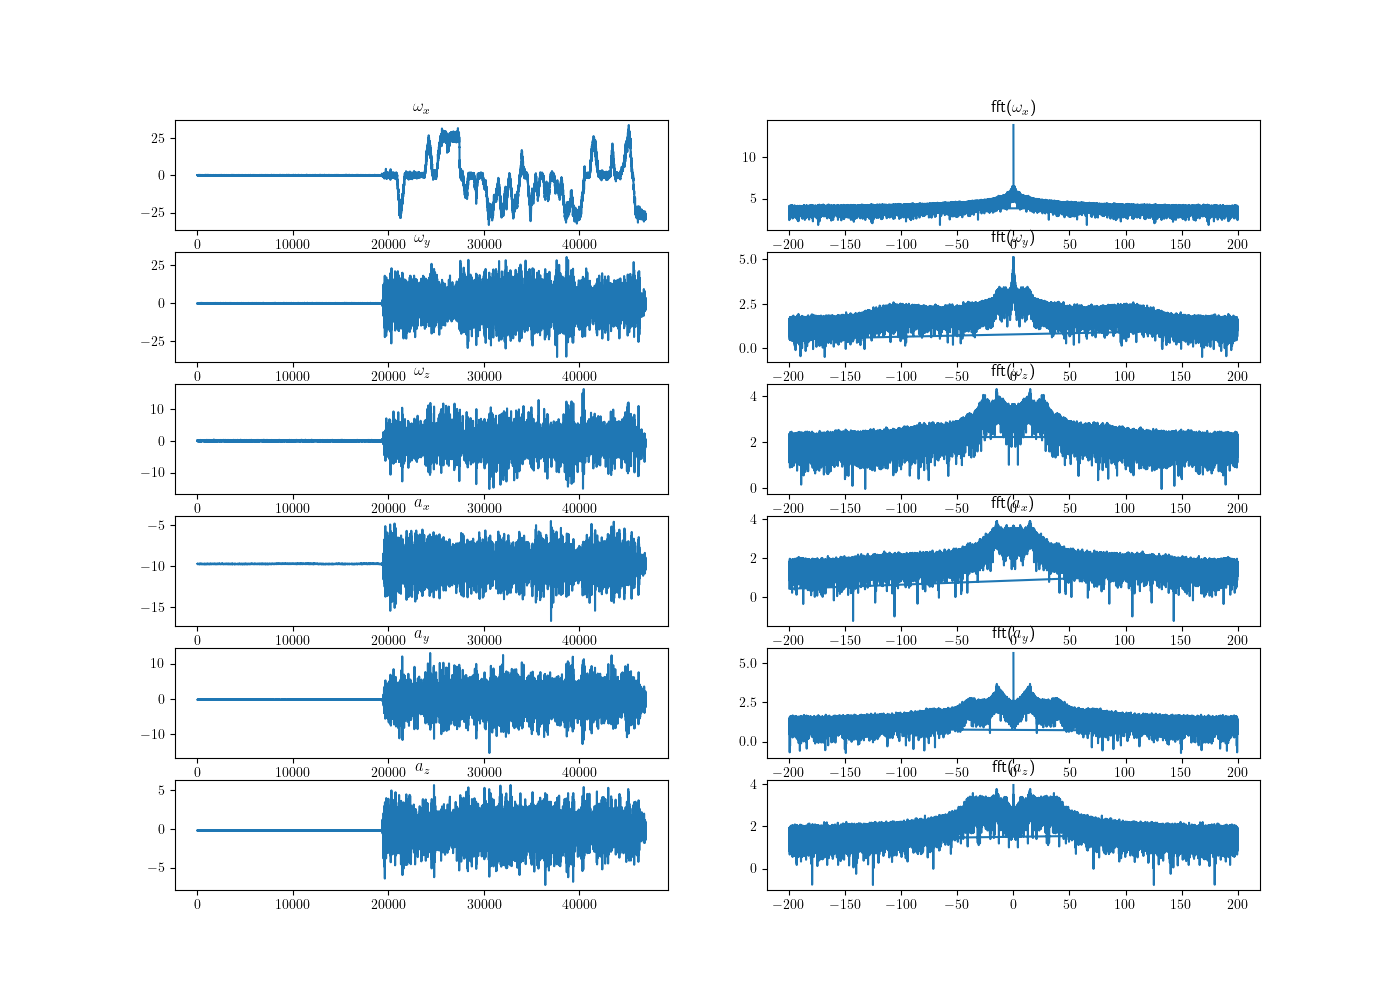

In [3]:
%matplotlib widget
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
titles = [
    "$\omega_x$",
    "$\omega_y$",
    "$\omega_z$",
    "$a_x$",
    "$a_y$",
    "$a_z$"]

plt.figure(figsize=(14,10))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.title(titles[i])
    plt.plot(df.iloc[:,i+1])
    plt.subplot(6,2,i*2+2)
    plt.title("fft("+titles[i]+")")
    plt.plot(np.fft.fftfreq(df.iloc[:,i].shape[0], 1/400),np.log10(np.abs(np.fft.fft(df.iloc[:,i].values))))
plt.show()
         

# Basic attempt at dead reckoning
Try a two dimensional integration with rotaion around vertial axis and movement forward and back. Use $\omega_x$ as rotational axis and $a_y$ as forward/backward acceleration.

In [4]:
w_x = df.iloc[:,1].values / 57.29578
a_y = df.iloc[:,5].values + 0.2436367406

pos = np.asarray([0, 0], dtype=float) #(x, y)
vel = 0 #m/s
O = 0 # rad/s orientation
dt = 1/400

pos_history = np.zeros((w_x.shape[0], 2))
vel_history = np.zeros((w_x.shape[0], 1))

for i in range(w_x.shape[0]):
    vel += a_y[i] * dt
    vel_history[i] = vel
    delta_s = vel * dt # Displacement at timestep

    O += w_x[i] * dt # Orientation
    delta_x = np.asarray([np.cos(O), np.sin(O)], dtype=float) * delta_s
    pos += delta_x
    pos_history[i, 0] = pos[0]
    pos_history[i, 1] = pos[1]    


<function matplotlib.pyplot.show(block=None)>

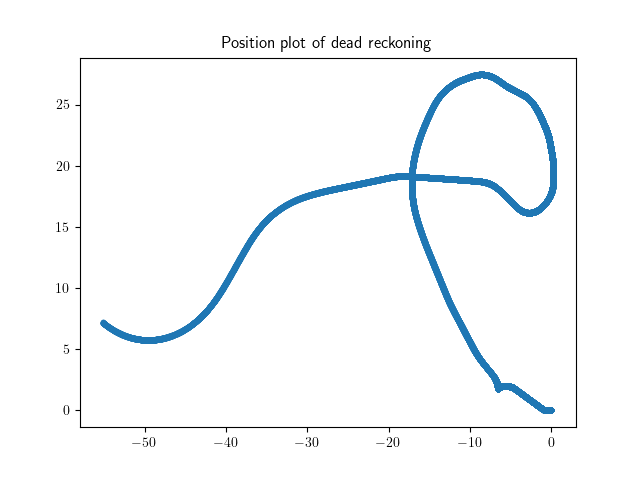

In [5]:
plt.figure()
plt.title("Position plot of dead reckoning")
plt.scatter(pos_history[:, 0], pos_history[:, 1], marker=".")
plt.show

<function matplotlib.pyplot.show(block=None)>

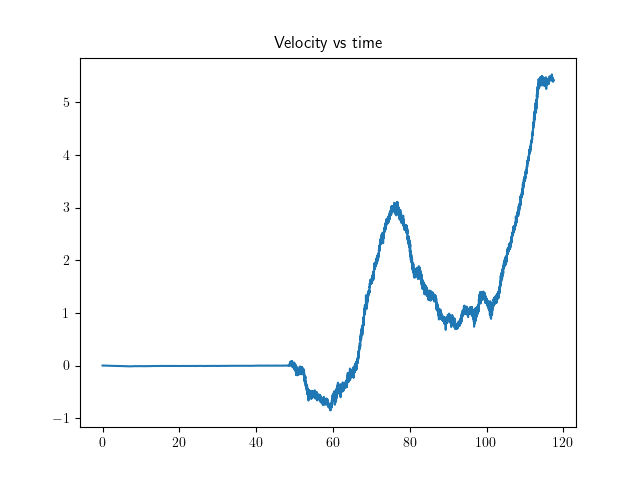

In [6]:
plt.figure()
plt.title("Velocity vs time")
t = np.arange(vel_history.shape[0]) * (1/400)
plt.plot(t, vel_history)
plt.show

# Finding gravity vector

<function matplotlib.pyplot.show(block=None)>

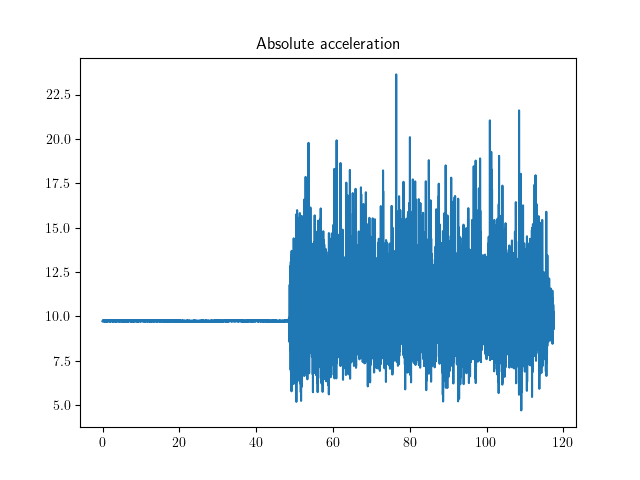

In [7]:
abs_a = np.sqrt(np.power(df.iloc[:,4].values, 2) + np.power(df.iloc[:,5].values, 2) + np.power(df.iloc[:,5].values, 2))

plt.figure()
plt.title("Absolute acceleration")
plt.plot(t, abs_a)
plt.show